In [1]:
import numpy as np
import tensorflow_datasets as tfds
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import datetime

tf.random.set_seed(27) # set seed for reproducibility

## Loading the data

We load the CIFAR-10 dataset from tensorflow_datasets instead of from keras datasets.

In [85]:
# Load data
train_ds, test_ds = tfds.load('cifar10', 
                              split=['train', 'test'], 
                              as_supervised=True, 
                              shuffle_files=False)

## Visualize examples from CIFAR-10

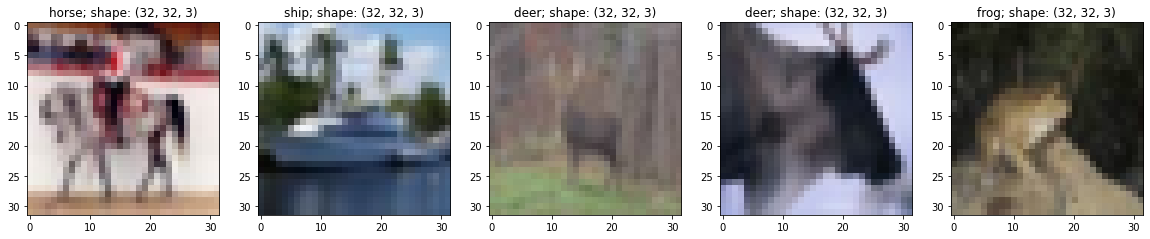

In [86]:
# visualize one example from each image class
num_plots = 5
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(20,4))
labelDic = {0: 'airplane', 
            1: 'automobile', 
            2: 'bird', 
            3: 'cat',
            4: 'deer',
            5: 'dog',
            6: 'frog',
            7: 'horse',
            8: 'ship',
            9: 'truck'}

# iterate over 5 batches and show the first image
for i, (img, label) in enumerate(train_ds.take(5)):
    label = labelDic[label.numpy()]
    axes[i].imshow(img)
    axes[i].set_title(f'{label}; shape: {img.shape}')

## Prepare the input pipeline

We perform the following steps for our input pipeline:

- shuffling (only on train),
-  batching (64)
- prefetching, 
- one-hot encoding the targets, 
- normalizing the images (to 0 mean and variance 1),
- casting the images to tf.float32.

In [87]:
# batch, shuffle, prefetch
def preprocess(dataset, batch_size=None, buffer_size=None, ds_length=None, ds_classes=None,prefetch_factor=None):
    '''
    Create an input pipeline

    :param dataset: tf.dataset to preprocess
    :param batch_size: int, default batch size is 64
    :param buffer_size: int, default is 1024
    :param prefetch_factor: int, default prefetch size is TF autotune
    :returns: tf.dataset
    '''
    
    if ds_classes is None:
        print('You have to define the amount of target classes => ds_classes')
        return None

    # set default batch size to 64
    if batch_size is None:  
        batch_size = 64

    # set default prefetch_factor to be autotune
    if buffer_size is None or ds_length is None:
        prefetch_factor = tf.data.experimental.AUTOTUNE

    elif prefetch_factor is None:
        prefetch_factor = int(ds_length/batch_size)
        
    # set buffer_size
    if buffer_size is None:
        buffer_size = 1024
    

    # create input pipeline using shuffling and batching
    dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
    
    # casting of the images to float32 and one hot encoding of the labels
    dataset = dataset.map(lambda img, label: (tf.cast(img, tf.float32)/255, tf.one_hot(label, depth=ds_classes)), 
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # standardizing the images to 0 mean and 1 variance
    dataset = dataset.map(lambda img, label: (tf.image.per_image_standardization(img), label), 
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # prefetch the dataset using AUTOTUNE to automatically find the optimal number of batches to prefetch
    dataset = dataset.prefetch(prefetch_factor)

    return dataset

In [88]:
# set batchsizes and then create our prefetched preprocessed train and test datasets
train_length = 50000
test_length = 10000
classes = 10
batchsize = 16  #should be a power of 2 (e.g. 4,8,16,32,64) to get the most out of GPU parallelization

train_ds = preprocess(train_ds, 
                      batch_size=batchsize, 
                      ds_length=train_length, 
                      ds_classes=classes)

test_ds = preprocess(test_ds, 
                     batch_size=batchsize, 
                     ds_classes=classes, 
                     ds_length=test_length)

## Implementing the Residual Block class
In **(0)** we inherit the class from tf.keras.layers.Layer

### Initializing the ResBlock

In **(1)** and **(2)** we initialize variables for further use in the call method.


There are two different types of ResBlock: one has a bottleneck, the other doesn't:

If the ResBlock is supposed to have a **bottleneck**, it will look like this:

**(3)**, **(4)** and **(6)**
- a 1x1 convolutional layer with activation and BN, 
- a 3x3 convolutional layer with activation and BN (padding set to same)
- a 1x1 convolutional layer with BN


If the ResBlock isn't supposed to have a **bottleneck**, it will look like this:

**(4)** and **(5)**:
- a 3x3 convolutional layer with activation and BN (padding set to same)
- a Spatial Dropout Layer (randomly dropping channels)
- a 3x3 convolutional layer with activation and BN (padding set to same)
- a Spatial Dropout Layer

Why are **(7)** and **(2)** needed?
The convolutional layers can have a number of filters differing from the number of channels in the ResBlocks input. This leads to shape incompatibility when trying to add the input to the output. To alleviate this problem we introduce an additional argument *equal_channels*. If the input channels and convolution's filters are equal, we don't need to manipulate the input. If however the input's dimension is lower or higher than the output's dimension, we apply an extra 1x1 convolution to the input.

In **(8)** we instantiate the Add layer, a ReLU for the output and a **Spatial Dropout Layer**, which **randomly drops channels** and can be used as an alternative to normal Dropout when training CNNs.


### Calling the ResBlock layer

In calling the layer, we first make a copy of the input **(9)**. Then we apply the layers that are used in the type of ResBlock (1 - 3 - 1 vs 3 - 3).

If it's a bottleneck ResBlock, we apply **(10)**, **(11)**.

If it's not a bottleneck ResBlock, we apply **(11)** and **(12)** (along with Spatial Dropout).

After having applied one of the two options, we expand or reduce the channels dimension for the input we copied in **(9)** by applying a 1x1 convolution to it **(13)**.

Finally for the bottleneck ResBlock, we apply a bottleneck layer **(14)**. 

We then add both the input and the output in **(15)**, and apply an activation function **(16)**, followed by a Spatial Dropout Layer **(17)**. 


In [2]:
class ResBlock(tf.keras.layers.Layer):                                             # (0)
    def __init__(self, filters, conv_size,
                 dropout_rate, reg, l2_lambda, 
                 activation_function, bottleneck = False, equal_channels = False):
        super(ResBlock, self).__init__()

        self.bottleneck = bottleneck                                               # (1)
        self.equal_channels = equal_channels                                       # (2)


        if bottleneck:                                                             # (3)
          self.conv1 = tf.keras.layers.Conv2D(filters, (1,1),                      # (3)
                                              padding='valid',                     
                                              kernel_regularizer=reg(l2_lambda))
          self.relu1 = tf.keras.layers.Activation(activation_function)             # (3)
          self.bn1 = tf.keras.layers.BatchNormalization()                          # (3)

        
        self.conv2 = tf.keras.layers.Conv2D(filters, conv_size,                    # (4)
                                            padding = 'same',                      # (4)
                                            kernel_regularizer=reg(l2_lambda))     # (4)
        self.bn2 = tf.keras.layers.BatchNormalization()                            # (4)
        self.relu2 = tf.keras.layers.Activation(activation_function)               # (4)
        self.spatial_do2 = tf.keras.layers.SpatialDropout2D(dropout_rate)

        if not bottleneck:                                                         # (5)
          self.conv2_2 = tf.keras.layers.Conv2D(filters,conv_size,                 # (5)
                                                padding="same",                    
                                                kernel_regularizer = reg(l2_lambda))
          self.relu2_2 = tf.keras.layers.Activation(activation_function)           # (5)
          self.bn2_2 = tf.keras.layers.BatchNormalization()                        # (5)
          self.spatial_do2_2 = tf.keras.layers.SpatialDropout2D(dropout_rate)

        if bottleneck:                                                             # (6)
          self.conv3 = tf.keras.layers.Conv2D(filters, (1,1),                      # (6)
                                              padding = 'valid',                   
                                              kernel_regularizer = reg(l2_lambda)) 
          self.bn3 = tf.keras.layers.BatchNormalization()                          # (6)


        if equal_channels:                                                         # (7)
          self.conv_equal_size = tf.keras.layers.Conv2D(filters, (1,1),            # (7)
                                                        kernel_regularizer = reg(l2_lambda))

        self.add = tf.keras.layers.Add()                                           # (8)
        self.relu_out = tf.keras.layers.Activation(activation_function)            # (8)
        self.spatial_do_out = tf.keras.layers.SpatialDropout2D(dropout_rate)       # (8)

    @tf.function
    def call(self, x, training):

        x_2 = tf.identity(x)                                                       # (9)

        if self.bottleneck:                                                        # (10)
          x = self.conv1(x)
          x = self.relu1(x)
          x = self.bn1(x, training)

        x = self.conv2(x)                                                          # (11)
        x = self.relu2(x)
        x = self.bn2(x, training)                                                  # (11)
        x = self.spatial_do2(x,training)                                           # (11)

        if not self.bottleneck:                                                    # (12)
          x = self.conv2_2(x)
          x = self.relu2_2(x)
          x = self.bn2_2(x,training)
          x = self.spatial_do2_2(x,training)

        if self.equal_channels:                                                    # (13)
          x_2 = self.conv_equal_size(x_2)

        if self.bottleneck:                                                        # (14)
          x = self.conv3(x)
          x = self.bn3(x, training)

        x = self.add([x, x_2])                                                     # (15)

        
        
        x = self.relu_out(x)                                                       # (16)
        x = self.spatial_do_out(x, training)                                       # (17)

        return x

## Implementing the ResNet model using the ResBlock class

We inherit our ResNet class from tf.keras.Model. This comes with some advantages that in this course we have not made use of so far. One advantage is that it allows to call the model.summary() method, which gives us parameter counts of the layers that the model is comprised of. In the model's summary, we can also store information that we obtain from metrics (loss, accuracy).

Again we first initialize our model's layers and then define the call method in which these layers will be applied. 

In **(1)** we instantiate a (7,7) Convolutional Layer with Batch Normalization and an activation function that can be set when instantiating the model.

In **(2)** we instantiate a list of ResBlocks. The number of ResBlocks depends on the number of blocks set in num_blocks.

In **(3)** we do the same for Batch Normalization Layers.

In **(4)** we instantiate a list of length num_blocks for Max-Pool layers. Since we only have 32x32 images, we can not apply max-pool too often. For this reason only the first two entries in the list will be MaxPool with the rest being functions that simply return their input.

In **(5)** and **(6)** instantiate GlobalAveragePooling and the output layer.

## Calling the ResNet

We apply the first convolution and then iterate through the three lists (ResBlocks, bn_layers and max_pool) and apply them in this order. **(7)**

Finally we apply the Global Pooling and the Output layer.

In [3]:
def return_same(x):
  return x



class ResNet(tf.keras.Model): 
  def __init__(self, num_blocks, 
               filters,equal_filters, 
               bottleneck_block, num_maxpool, dropout_rate, 
               l2_lambda,activation_function, reg):
    super(ResNet, self).__init__()

    self.conv = tf.keras.layers.Convolution2D(filters[0],(7,7),strides = (1,1), 
                                              kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))          # (1)
    self.bn = tf.keras.layers.BatchNormalization()                                                             # (1)
    self.relu = tf.keras.layers.Activation(activation_function)                                                # (1)
                                                                                                               
    filters = filters[1:]
    self.resblocks = [ResBlock(filters[i],
                              (3,3),dropout_rate, reg,
                              l2_lambda, activation_function, 
                              bottleneck_block[i], equal_channels=equal_filters[i]) for i in range(num_blocks)]            # (2)

    self.bn_layers = [tf.keras.layers.BatchNormalization() for _ in range(num_blocks)]                         # (3)

    self.max_pool= [tf.keras.layers.MaxPool2D() if i < num_maxpool else return_same for i in range(num_blocks)]            # (4)

    

    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()                                                # (5)
    self.out = tf.keras.layers.Dense(10,activation= "softmax")                                                 # (6)

  @tf.function
  def call(self,x, training):
    x = self.conv(x)
    x = self.relu(x)
    x = self.bn(x,training)


    for (max_pool, res_block, bn) in zip(self.max_pool, self.resblocks, self.bn_layers):                       # (7)

      x = res_block(x,training)
      x = bn(x,training)
      x = max_pool(x)

    x = self.global_pool(x)
    x = self.out(x)

    return x

## Defining a timer, train-step and test functions

We define a timer class to keep track of the time it takes to train the model.

We then define our training step (which here performs an epoch) and our test function. Here we use loss and accuracy metrics in a way that so far has not been introduced by the course. 

### A different use of keras metrics
The idea is to not use any list operations like appending or numpy calls since this is not allowed when using the @tf.function decorator. It turns out that keras metrics allow for states to be stored. 

In train_step, after each batch, loss and accuracy metric objects are updated by using their "update_state" method.

In the evaluation function, we do the same just without calculating gradients and applying them with an optimizer.


In [4]:
class Timer():
    """
    A small class for making timings.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        return elapsed_time  

@tf.function
def train_step(model, train_ds, loss_function, optimizer, train_loss_metric, train_acc_metric):
    '''
    Training for one epoch.
    '''
    for img, target in train_ds:
        # forward pass with GradientTape
        with tf.GradientTape() as tape:
            prediction = model(img, training=True)
            loss = loss_function(target, prediction)
            loss_reg = loss + tf.reduce_sum(model.losses)

        # backward pass via GradienTape (auto-gradient calc)
        gradients = tape.gradient(loss_reg, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)
        train_acc_metric.update_state(target, prediction)

@tf.function
def eval_step(model, ds, loss_function, loss_metric, acc_metric):
    '''
    Evaluation Loop.
    '''
    for img, target in ds:
        # forward pass
        prediction = model(img, training=False)
        # update metrics
        loss = loss_function(target, prediction)
        loss_metric.update_state(loss)
        acc_metric.update_state(target, prediction)

## Setting Hyperparameters
- epochs
- learning_rate
- beta_1 (first momentum of Adam Optimizer)
- dropout_rate (Spatial Dropout: rate of Channels to be dropped after each ResBlock)
- l2_lambda (linearly scales model complexity penalization/regularization)

- num_blocks (number of Residual Blocks)
- filters (list of filter numbers. First entry is for the 7x7 conv layer)
- maximum number of max pool layers to use
- Bottleneck_res (list of booleans specifying if a ResBlock is supposed to be of type 1-3-1 or 3-3)

- activation_function
- regularizer (e.g. l1, l2)

In [5]:
epochs = 25
learning_rate = 0.0003
beta_1 = 0.95
dropout_rate = 0.125 # defines the rate of channels to be dropped after each convolution
l2_lambda = 0.0001

num_blocks = 3        # number of residual blocks.

filters = [32, 64, 128, 256] # first filter is not for a block but for first convolution

num_maxpool = 2

equal_filters = [False if filters[i] == filters[i-1] else True for i in range(1,num_blocks+1) ]

Bottleneck_block = [False,False,False,False]

reg = tf.keras.regularizers.l2 


activation_function = tf.nn.relu  #You can change this to any activation function you like. We tried leaky_relu but it was slower than normal relu.

tf.keras.backend.clear_session() #clear session from previous models
timer = Timer() # Instantiate the timer

model = ResNet(num_blocks = num_blocks, 
               filters = filters, 
               equal_filters = equal_filters,
               bottleneck_block = Bottleneck_block, 
               num_maxpool = num_maxpool,
               dropout_rate = dropout_rate, 
               l2_lambda = l2_lambda, 
               activation_function = activation_function,
               reg = reg)                           # Instantiate the model.

loss_function = tf.keras.losses.CategoricalCrossentropy() # Instantiate model loss
optimizer = tf.keras.optimizers.Adam(learning_rate,  beta_1) # Instantiate Adam optimizer

model.build((None,32,32,3)) # build the model (needed to do the summary)
model.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  4736      
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
res_block (ResBlock)         multiple                  58048     
_________________________________________________________________
res_block_1 (ResBlock)       multiple                  230784    
_________________________________________________________________
res_block_2 (ResBlock)       multiple                  920320    
_________________________________________________________________
batch_normalization_7 (Batch multiple                  256 

## Instantiate metric objects to be used in training and evaluation

We instantiate CategoricalAccuracy objects for train and test.

We also instantiate a mean metric for the loss, since we are interested in the mean loss per epoch.

## Using the **TensorBoard** for visualization

This is an elegant alternative to plotting with matplotlib. The tensorboard allows us to interactively explore our different training runs. It allows to interactively use a slider for the smoothing.

To use the tensorboard, it is required to set up **log files** and a **logger object** with *tf.summary.create_file_writer(log_file)*

On top we also define lists for matplotlib visualization (not needed for Tensorboard though)

In [104]:
# prepare metrics
train_acc_metric = tf.keras.metrics.CategoricalAccuracy('train_accuracy')
test_acc_metric = tf.keras.metrics.CategoricalAccuracy('test_accuracy')

train_loss_metric = tf.keras.metrics.Mean('train_loss')
test_loss_metric = tf.keras.metrics.Mean('test_loss')

# initialize the logger for Tensorboard visualization
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train_ResNet'      # defining the log dir
test_log_dir = 'logs/gradient_tape/' + current_time + '/test_ResNet'        # defining the log dir
train_summary_writer = tf.summary.create_file_writer(train_log_dir)  # training logger
test_summary_writer = tf.summary.create_file_writer(test_log_dir)    # test logger

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
times = []

## FINALLY: Training our ResNet on CIFAR-10

Before training, we first evaluate the model on the train and test dataset. After having done so, we reset the metrics object's states.

After that we iterate over the epochs.

In each epoch, we do the train-step (on the entire train-data), which updates the loss and accuracy metrics. We then store the loss and accuracy results using our tf.summary logger/writer along with the epoch number. We also evaluate the model on the test data and also store that information.

At the end of an epoch, we reset our loss and accuracy metrics objects (this could also be done before doing the train_step and evaluation).



In [105]:
print(f'[INFO] - Evaluating the Dataset on the {model.name} before training.')
timer.start()

# Evaluating the train dataset on the Model before training
eval_step(model, train_ds, loss_function, 
          loss_metric=train_loss_metric, 
          acc_metric=train_acc_metric)

train_loss = train_loss_metric.result()
train_acc = train_acc_metric.result()
train_losses.append(train_loss)
train_accuracies.append(train_acc)

# Evaluating the test dataset on the Model before training
eval_step(model, test_ds, loss_function, 
          loss_metric=test_loss_metric, 
          acc_metric=test_acc_metric)

test_loss = test_loss_metric.result()
test_acc = test_acc_metric.result()
test_losses.append(test_loss)
test_accuracies.append(test_acc)

# Resetting train and test metrics
train_acc_metric.reset_states()
test_acc_metric.reset_states()
train_loss_metric.reset_states()
test_loss_metric.reset_states()

elapsed_time = timer.stop()
times.append(elapsed_time)

print(f'train_loss: {train_loss:0.4f}, train_acc: {train_acc:0.4f}, test_loss: {test_loss:0.4f}, test_acc: {test_acc:0.4f}')

for epoch in range(epochs):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    # training step with metrics update--------------------------------------------------------
    timer.start()

    train_step(model, train_ds, loss_function, optimizer, train_loss_metric, train_acc_metric)

    # Evaluating training metrics
    train_loss = train_loss_metric.result()
    train_acc = train_acc_metric.result()
    
    with train_summary_writer.as_default():     # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', train_loss, step=epoch)
        tf.summary.scalar('accuracy', train_acc, step=epoch)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)
    
    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}, train_acc: {train_acc:0.4f}')
    
    # evaluation step with metrics update--------------------------------------------------------
    timer.start()

    eval_step(model, test_ds, loss_function, 
              loss_metric=test_loss_metric, 
              acc_metric=test_acc_metric)

    # Evaluating validation metrics
    test_loss = test_loss_metric.result()
    test_acc = test_acc_metric.result()
    
    with test_summary_writer.as_default():       # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', test_loss, step=epoch)
        tf.summary.scalar('accuracy', test_acc, step=epoch)
    
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f'\n[{epoch}] - Finished evaluation - test_loss: {test_loss:0.4f}, test_accuracy: {test_acc:0.4f}')
    
    # Resetting train and validation metrics-----------------------------------------------------
    train_acc_metric.reset_states()
    test_acc_metric.reset_states()
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)
  
    if epoch%3 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.')

print(f'[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

[INFO] - Evaluating the Dataset on the res_net before training.
train_loss: 2.3652, train_acc: 0.1000, test_loss: 2.3647, test_acc: 0.1000

[EPOCH] ____________________0____________________
[0] - Finished Epoch in 30.44 seconds - train_loss: 1.6055, train_acc: 0.4182

[0] - Finished evaluation - test_loss: 1.1667, test_accuracy: 0.5815

[INFO] - Total time elapsed: 0.7213 min. Total time remaining: 17.3110 min.

[EPOCH] ____________________1____________________
[1] - Finished Epoch in 28.60 seconds - train_loss: 1.2216, train_acc: 0.5700

[1] - Finished evaluation - test_loss: 0.9132, test_accuracy: 0.6835

[EPOCH] ____________________2____________________
[2] - Finished Epoch in 28.23 seconds - train_loss: 1.0123, train_acc: 0.6506

[2] - Finished evaluation - test_loss: 0.7547, test_accuracy: 0.7430

[EPOCH] ____________________3____________________
[3] - Finished Epoch in 28.64 seconds - train_loss: 0.8806, train_acc: 0.7000

[3] - Finished evaluation - test_loss: 0.6730, test_accur

## Visualizing the ResNet training

- we see that the train loss and accuracy are worse than the test loss/accuracy. This is because the train loss and accuracy were computed with dropout and the test without. If you want accurate comparisons you need to perform a test step on the whole training data in every epoch, which leads to significantly higher training time.

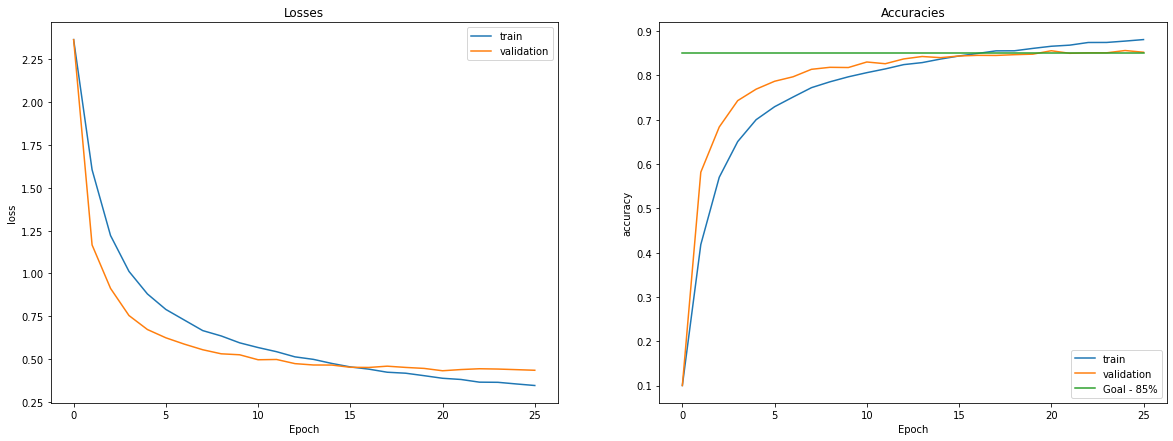

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

x = np.arange(len(train_losses))

# losses
axes[0].plot(x, train_losses, label='train')
axes[0].plot(x, test_losses, label='test')
axes[0].legend()
axes[0].set(title='Losses', xlabel='Epoch', ylabel='loss')

# accuracies
axes[1].plot(x, train_accuracies, label='train')
axes[1].plot(x, test_accuracies, label='test')
axes[1].plot([0.85 for _ in range(len(test_accuracies))], label='Goal - 85%')
axes[1].legend()
axes[1].set(title='Accuracies', xlabel='Epoch', ylabel='accuracy')

plt.show()

## Using the TensorBoard
(works on Colab but might require you to install the tensorboard on your local machine)

Run the code below and set smoothing and untick all training runs that you don't want to be plotted

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/gradient_tape

## Creating a DenseNet

To create the DenseNet, we define three classes that inherit from tf.keras.layers.Layer. The basic building-blocks are DenseLayers, in which a bottleneck is applied (here fixed to 32 channels), followed by a normal Convolutional Layer. Spatial Dropout (see ResNet text from above for explanation) and BatchNorm are used for regularization. The input from the dense net is concatenated (stacked along the channels axis) with it's output, effectively increasing the number of feature maps (this is why we include a bottleneck at the beginning of each DenseLayer). The next level of layer is a DenseBlock. A DenseBlock does nothing more than applying a number of DenseLayers to it's input (sequentially that is). 

A transition layer performs a bottleneck with max pooling along with an activation function. This layer is used after each DenseBlock except for the last DenseBlock, which leads to a fully connected layer after global average pooling

In [134]:
class Transition(tf.keras.layers.Layer):

    def __init__(self, filter_num, activation="relu"):
        super(Transition, self).__init__()
        
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.bottelneck = tf.keras.layers.Conv2D(filter_num, 
                                                 kernel_size=(1,1), 
                                                 strides=(1,1), 
                                                 padding='valid')
        
        
        self.pool = tf.keras.layers.MaxPooling2D()
        
        
        self.activation = tf.keras.layers.Activation(activation) 
        
    
    def call(self, x, training=False):

        x = self.batchnorm(x, training)
        x = self.bottelneck(x)
        x = self.pool(x)
        x = self.activation(x)
        
        return x

class DenseLayer(tf.keras.layers.Layer):

    def __init__(self, filter_num, activation,dropout_rate,reg,l2_lambda):
        super(DenseLayer, self).__init__()
        # turn off regularization if lambda == 0
        if l2_lambda >0:
          r = reg(l2_lambda)
        else:
          r = None          

        self.bottleneck = tf.keras.layers.Conv2D(32,
                                                 kernel_size=(1,1),
                                                 strides=(1,1),
                                                 padding='valid',
                                                 kernel_regularizer = r)
        self.bn0 = tf.keras.layers.BatchNormalization()

        self.conv = tf.keras.layers.Conv2D(filter_num,
                                           kernel_size=(3,3),
                                           strides=(1,1),
                                           padding='same',
                                           kernel_regularizer = r)
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.acti1 =tf.keras.layers.Activation(activation)
        self.spatial_do = tf.keras.layers.SpatialDropout2D(dropout_rate)
    
    def call(self, x, training=False):
        x_old = tf.identity(x)

        x = self.bottleneck(x)
        x = self.bn0(x, training)
        
        x = self.conv(x)
        x = self.bn1(x, training)
        x = self.acti1(x)

        
        x = tf.keras.layers.concatenate([x_old, x], axis=-1)
        x = self.spatial_do(x,training)
        
        return x


class DenseBlock(tf.keras.layers.Layer):

    def __init__(self, num_DL, growth_rate,dropout_rate, reg,l2_lambda,activation='relu'):
        super(DenseBlock, self).__init__()
        
        self.dense_layers = [DenseLayer(growth_rate,activation,dropout_rate,reg,l2_lambda) for _ in range(num_DL)]
        
    
    def call(self, x, training=False):
                                                 
        for denseLayer in self.dense_layers:
            x = denseLayer(x, training)  
                                                 
        return x

In [135]:
def return_input(x, training):
    return x

class DenseNet(tf.keras.Model):
    
    def __init__(self, growth_rate, num_DenseLayers, transitionLayer_features, dropout_rate,dropout_dense,reg,l2_lambda,activation, initial_kernel=16):
        
        super(DenseNet, self).__init__()
        
        self.initial_kernel = initial_kernel
        # turn off regularization alltogether if lambda == 0

        if l2_lambda >0:
          r = reg(l2_lambda)
        else:
          r = None

        self.conv0 = tf.keras.layers.Conv2D(filters=self.initial_kernel, 
                                            kernel_size=(7,7), 
                                            strides=(1,1),
                                            padding='same',
                                            kernel_regularizer = r)  # just to get good channel dim.
        
        self.dense = []
        self.trans = []
        
        for num_Dl, grate in zip(num_DenseLayers, growth_rate):
            self.dense.append(DenseBlock(num_Dl, grate,dropout_rate,reg,l2_lambda,activation))
            
        for trans_features in transitionLayer_features:
            self.trans.append(Transition(trans_features))
            
        if len(self.dense) != len(self.trans):
            self.trans.append(return_input)

        self.pool_end = tf.keras.layers.GlobalAveragePooling2D()
        self.full = tf.keras.layers.Dense(256, activation='relu')
        self.drop = tf.keras.layers.Dropout(dropout_dense)
        self.softmax = tf.keras.layers.Dense(10, activation='softmax')


    
    def call(self, x, training=False):
        x = self.conv0(x)
        
        for dense, trans in zip(self.dense, self.trans):
            x = dense(x, training)
            x = trans(x, training)

        
        x = self.pool_end(x)
        x = self.full(x)
        x = self.drop(x)
        x = self.softmax(x)
        return x

In [136]:
class Timer():
    """
    A small class for making timings.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        return elapsed_time  

@tf.function
def train_step(model, train_ds, loss_function, optimizer, train_loss_metric, train_acc_metric):
    '''
    Training for one epoch.
    '''
    for img, target in train_ds:
        # forward pass with GradientTape
        with tf.GradientTape() as tape:
            prediction = model(img, training=True)
            loss = loss_function(target, prediction)
            loss_reg = loss + tf.reduce_sum(model.losses)

        # backward pass via GradienTape (auto-gradient calc)
        gradients = tape.gradient(loss_reg, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)
        train_acc_metric.update_state(target, prediction)

@tf.function
def eval_step(model, ds, loss_function, loss_metric, acc_metric):
    '''
    Evaluation Loop.
    '''
    for img, target in ds:
        # forward pass
        prediction = model(img, training=False)
        # update metrics
        loss = loss_function(target, prediction)
        loss_metric.update_state(loss)
        acc_metric.update_state(target, prediction)

In [137]:
# prepare metrics
train_acc_metric = tf.keras.metrics.CategoricalAccuracy('train_accuracy')
test_acc_metric = tf.keras.metrics.CategoricalAccuracy('test_accuracy')

train_loss_metric = tf.keras.metrics.Mean('train_loss')
test_loss_metric = tf.keras.metrics.Mean('test_loss')

# initialize the logger for Tensorboard visualization
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train_DenseNet'      # defining the log dir
test_log_dir = 'logs/gradient_tape/' + current_time + '/test_DenseNet'        # defining the log dir
train_summary_writer = tf.summary.create_file_writer(train_log_dir)  # training logger
test_summary_writer = tf.summary.create_file_writer(test_log_dir)    # test logger

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
times = []

In [138]:
epochs = 45
learning_rate = 0.0003
beta_1 = 0.95
dropout_rate = 0.1 # defines the rate of channels to be dropped after each convolution
dropout_dense = 0.2
l2_lambda = 0
reg = tf.keras.regularizers.l2
activation = tf.nn.relu

tf.keras.backend.clear_session() #clear session from previous models

timer = Timer() # Instantiate the timer

growth_rate = [32, 32, 32] #, 32, 32]
num_DenseLayers = [2, 4, 6] #, 14, 16]
transitionLayer_Features = [64, 128] #, 256, 512]

initial_filters = 32

# Instantiate the model.
model = DenseNet(growth_rate = growth_rate, 
                 num_DenseLayers = num_DenseLayers, 
                 transitionLayer_features = transitionLayer_Features,
                 initial_kernel = initial_filters,
                 dropout_rate = dropout_rate,
                 dropout_dense = dropout_dense,
                 reg = reg,
                 l2_lambda = l2_lambda,
                 activation = activation)


loss_function = tf.keras.losses.CategoricalCrossentropy() # Instantiate model loss
optimizer = tf.keras.optimizers.Adam(learning_rate,  beta_1) # Instantiate Adam optimizer

model.build(input_shape=(None,32,32,3)) # build the model (needed to do the summary)
model.summary()

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  4736      
_________________________________________________________________
dense_block (DenseBlock)     multiple                  22144     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  52480     
_________________________________________________________________
dense_block_2 (DenseBlock)   multiple                  97152     
_________________________________________________________________
transition (Transition)      multiple                  6592      
_________________________________________________________________
transition_1 (Transition)    multiple                  25472     
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0 

In [139]:
print(f'[INFO] - Evaluating the Dataset on the {model.name} before training.')
timer.start()

# Evaluating the train dataset on the Model before training
eval_step(model, train_ds, loss_function, 
          loss_metric=train_loss_metric, 
          acc_metric=train_acc_metric)

train_loss = train_loss_metric.result()
train_acc = train_acc_metric.result()
train_losses.append(train_loss)
train_accuracies.append(train_acc)

# Evaluating the test dataset on the Model before training
eval_step(model, test_ds, loss_function, 
          loss_metric=test_loss_metric, 
          acc_metric=test_acc_metric)

test_loss = test_loss_metric.result()
test_acc = test_acc_metric.result()
test_losses.append(test_loss)
test_accuracies.append(test_acc)

# Resetting train and test metrics
train_acc_metric.reset_states()
test_acc_metric.reset_states()
train_loss_metric.reset_states()
test_loss_metric.reset_states()

elapsed_time = timer.stop()
times.append(elapsed_time)

print(f'train_loss: {train_loss:0.4f}, train_acc: {train_acc:0.4f}, test_loss: {test_loss:0.4f}, test_acc: {test_acc:0.4f}')

for epoch in range(epochs):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    # training step with metrics update--------------------------------------------------------
    timer.start()

    train_step(model, train_ds, loss_function, optimizer, train_loss_metric, train_acc_metric)

    # Evaluating training metrics
    train_loss = train_loss_metric.result()
    train_acc = train_acc_metric.result()
    
    with train_summary_writer.as_default():     # logging our metric results to a file which is used by tensorboard
        tf.summary.scalar('loss', train_loss, step=epoch)
        tf.summary.scalar('accuracy', train_acc, step=epoch)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)
    
    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}, train_acc: {train_acc:0.4f}')
    
    # evaluation step with metrics update--------------------------------------------------------
    timer.start()

    eval_step(model, test_ds, loss_function, 
              loss_metric=test_loss_metric, 
              acc_metric=test_acc_metric)

    # Evaluating validation metrics
    test_loss = test_loss_metric.result()
    test_acc = test_acc_metric.result()
    
    with test_summary_writer.as_default():       # logging our metric results to a file which is used by tensorboard
        tf.summary.scalar('loss', test_loss, step=epoch)
        tf.summary.scalar('accuracy', test_acc, step=epoch)
    
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f'\n[{epoch}] - Finished evaluation - test_loss: {test_loss:0.4f}, test_accuracy: {test_acc:0.4f}')
    
    # Resetting train and validation metrics-----------------------------------------------------
    train_acc_metric.reset_states()
    test_acc_metric.reset_states()
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()

    elapsed_time = timer.stop()
    times.append(elapsed_time)

    if epoch%3 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.')

print(f'[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

[INFO] - Evaluating the Dataset on the dense_net before training.
train_loss: 2.3124, train_acc: 0.1000, test_loss: 2.3118, test_acc: 0.1000

[EPOCH] ____________________0____________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/operators/control_flow.py:684: UserWarning: Seed 27 from outer graph might be getting used by function tf_data_experimental_scan_scan_body, if the random op has not been provided any seed. Explicitly set the seed in the function if this is not the intended behavior.
  ds = _general_purpose_scan(ds, init_vars, scan_body)


[0] - Finished Epoch in 37.00 seconds - train_loss: 1.9161, train_acc: 0.2775

[0] - Finished evaluation - test_loss: 1.5937, test_accuracy: 0.3977

[INFO] - Total time elapsed: 0.8649 min. Total time remaining: 38.0558 min.

[EPOCH] ____________________1____________________
[1] - Finished Epoch in 34.11 seconds - train_loss: 1.6473, train_acc: 0.3926

[1] - Finished evaluation - test_loss: 1.3746, test_accuracy: 0.4954

[EPOCH] ____________________2____________________
[2] - Finished Epoch in 34.38 seconds - train_loss: 1.4753, train_acc: 0.4617

[2] - Finished evaluation - test_loss: 1.1835, test_accuracy: 0.5650

[EPOCH] ____________________3____________________
[3] - Finished Epoch in 34.41 seconds - train_loss: 1.3361, train_acc: 0.5174

[3] - Finished evaluation - test_loss: 1.0724, test_accuracy: 0.6090

[INFO] - Total time elapsed: 2.6873 min. Total time remaining: 27.5451 min.

[EPOCH] ____________________4____________________
[4] - Finished Epoch in 34.07 seconds - train_loss

## Visualizing the DenseNet training

- a comparison between ResNet and DenseNet can be done using the Tensorboard!

- we see that the train loss and accuracy are worse than the test loss/accuracy. This is because the train loss and accuracy were computed with dropout and the test without. If you want accurate comparisons you need to perform a test step on the whole training data in every epoch, which leads to significantly higher training time.

When comparing ResNet and DenseNet based on our results, it is to note that the ResNet we found most successful has significantly more parameters. 

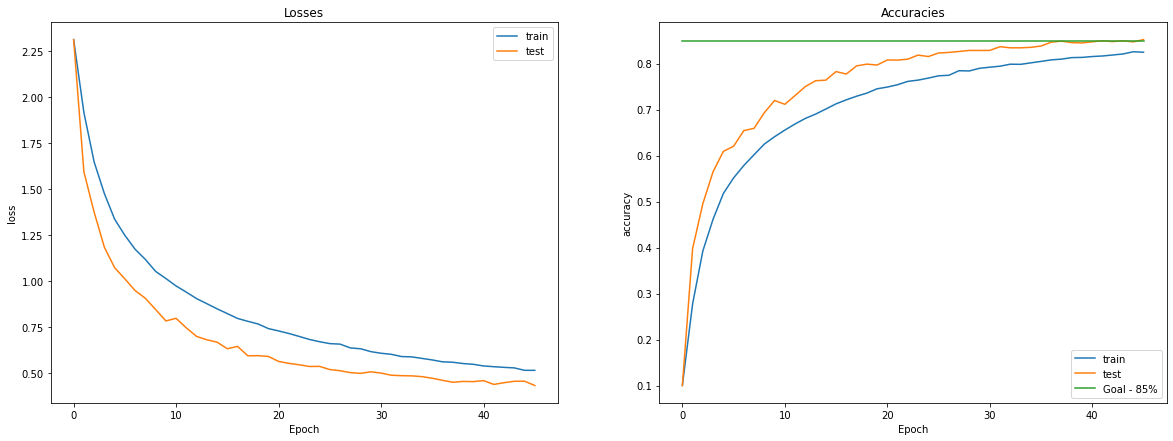

In [141]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

x = np.arange(len(train_losses))

# losses
axes[0].plot(x, train_losses, label='train')
axes[0].plot(x, test_losses, label='test')
axes[0].legend()
axes[0].set(title='Losses', xlabel='Epoch', ylabel='loss')

# accuracies
axes[1].plot(x, train_accuracies, label='train')
axes[1].plot(x, test_accuracies, label='test')
axes[1].plot([0.85 for _ in range(len(test_accuracies))], label='Goal - 85%')
axes[1].legend()
axes[1].set(title='Accuracies', xlabel='Epoch', ylabel='accuracy')

plt.show()